In [ ]:
# pip install brminer

In [ ]:
pip install scikit-posthocs

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import csv

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture

# import brminer

# the new model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import zipfile
from os import mkdir

import numpy as np
import math
import seaborn as sns
import os
import random
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import chebyshev
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Modified BRMiner

In [ ]:
class modified_BRM(BaseEstimator):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False,
                 bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95,
                 dissimilarity_measure = euclidean_distances):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        self.dissimilarity_measure = dissimilarity_measure

    def _evaluate(self, current_similarity):
        if (current_similarity < 0):
            current_similarity = 0

        if (self.use_past_even_queue == False):
            return -1+2*current_similarity
        
        result_similarity = (self.alpha * self._similarity_sum / self.max_event_count + (1 - self.alpha) * current_similarity)
        if (result_similarity < 0):
            result_similarity = 0

        self._similarity_sum += current_similarity

        if (len(self._past_events) == self.max_event_count):
            self._similarity_sum -= self._past_events.pop(0)

        self._past_events.append(current_similarity)

        if (self._similarity_sum < 0):
            self._similarity_sum = 0

        return -1+2*result_similarity

    def score_samples(self, X):
        X = np.array(X)
        X_test = self._scaler.transform(X)

        result = []
        batch_size = 100
        for i in range(min(len(X_test), batch_size), len(X_test) + batch_size, batch_size):
            current_X_test = X_test[[j for j in range(max(0, i-batch_size), min(i, len(X_test)))]]

            current_similarity = np.average([np.exp(-np.power(np.amin(self.dissimilarity_measure(current_X_test, self._centers[i]), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        
            result = result + [j for j in list(map(self._evaluate, current_similarity))]

        return result
        

    def predict(self, X):
        if (len(X.shape) < 2):
            raise ValueError('Reshape your data')

        if (X.shape[1] != self.n_features_in_):
            raise ValueError('Reshape your data')

        if not self._is_threshold_Computed:            
            x_pred_classif = self.score_samples(self._X_train)            
            x_pred_classif.sort()
            self._inner_threshold = x_pred_classif[(100-self.user_threshold)*len(x_pred_classif)//100]
            self._is_threshold_Computed = True

        y_pred_classif = self.score_samples(X)
        return [-1 if s <= self._inner_threshold else 1 for s in y_pred_classif]
        

    def fit(self, X, y = None):
        # Check that X and y have correct shape
        if y is not None:
            X_train, y_train = check_X_y(X, y)
        else:
             X_train = check_array(X)
             
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(euclidean_distances(centers, centers))/self._max_dissimilarity)**2)

        return self

In [ ]:
# Function importing Dataset 
def import_data(trainFile, testFile): 
    train = pd.read_csv(trainFile, sep= ',') 
    test = pd.read_csv(testFile, sep= ',') 
    return train, test    

# Function to split target from data 
def split_dataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    
    mm_scaler = MinMaxScaler()
    X_train_minmax = pd.DataFrame(mm_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_minmax = pd.DataFrame(mm_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    std_scaler = StandardScaler()
    X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_std = pd.DataFrame(std_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    X_train_minmax_std = pd.DataFrame(std_scaler.fit_transform(X_train_minmax[X_train_minmax.columns]), index=X_train_minmax.index, columns=X_train_minmax.columns)
    X_test_minmax_std = pd.DataFrame(std_scaler.transform(X_test_minmax[X_test_minmax.columns]), index=X_test_minmax.index, columns=X_test_minmax.columns)
    
    return X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std

# Function to make predictions 
def prediction(X_test, clf_object):  
    y_pred = clf_object.score_samples(X_test) 
    return y_pred 

def result_of_Class(y_test, y_pred, saveFile):       
    np.savetxt(saveFile, y_pred, fmt='%.4f')

In [ ]:
def unzip_files(zip_file):
  zip_ref = zipfile.ZipFile(zip_file, 'r')
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
unzip_files("Unsupervised_Anomaly_Detection.zip")

In [ ]:
# mkdir('Unsupervised_Anomaly_Detection_csv')
# mkdir('Unsupervised_Anomaly_Detection_csv/abalone19')
def read_dat_files(dir_name):
  mkdir(dir_name + '_csv')
  subdirList = os.listdir(dir_name)
  # print(subdirList)
  for subdir in subdirList:
    mkdir(dir_name + '_csv' + '/' + subdir)
  # print(subdir)
    for f in os.listdir(dir_name + '/' + subdir):
      print('Converting {} file into .csv'.format(f))
      columns = []
      datContent = []
      for line in open(dir_name + '/' + subdir + '/' + f).readlines():
        if '@attribute' in line:
          columns.append(line.split()[1])
        if '@' not in line:
          datContent.append(line.strip().replace(',',' ').split())
          if 'tra' in f and 'positive' in line:
            datContent.pop()
          # print(datContent)
      # print(datContent)
      pd.DataFrame(datContent, columns = columns).to_csv('Unsupervised_Anomaly_Detection_csv/' + subdir + '/'+ f + '.csv', index = False)


In [ ]:
!rm -rf Unsupervised_Anomaly_Detection_csv

In [ ]:
read_dat_files(dir_name = 'Unsupervised_Anomaly_Detection')

Converting ecoli-0-1-4-7_vs_2-3-5-6-5-1tst.dat file into .csv
Converting ecoli-0-1-4-7_vs_2-3-5-6-5-1tra.dat file into .csv
Converting yeast1-5-1tra.dat file into .csv
Converting yeast1-5-1tst.dat file into .csv
Converting dermatology-6-5-1tst.dat file into .csv
Converting dermatology-6-5-1tra.dat file into .csv
Converting abalone19-5-1tra.dat file into .csv
Converting abalone19-5-1tst.dat file into .csv
Converting poker-8-9_vs_6-5-1tra.dat file into .csv
Converting poker-8-9_vs_6-5-1tst.dat file into .csv
Converting winequality-red-8_vs_6-7-5-1tst.dat file into .csv
Converting winequality-red-8_vs_6-7-5-1tra.dat file into .csv
Converting winequality-white-9_vs_4-5-1tst.dat file into .csv
Converting winequality-white-9_vs_4-5-1tra.dat file into .csv
Converting kr-vs-k-zero_vs_eight-5-1tra.dat file into .csv
Converting kr-vs-k-zero_vs_eight-5-1tst.dat file into .csv
Converting ecoli-0-2-3-4_vs_5-5-1tst.dat file into .csv
Converting ecoli-0-2-3-4_vs_5-5-1tra.dat file into .csv
Converting

# One class classification

## BRM euclidean distance (default)

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()
clf_classif = modified_BRM()
clf_classif_minmax = modified_BRM()
clf_classif_std = modified_BRM()
clf_classif_minmax_std = modified_BRM()
data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__ + '_' + clf_classif.dissimilarity_measure.__name__ + '_' + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat.csv
AUC: 0.9261363636363636
AUC MinMax: 0.9261363636363636
AUC Std: 0.9261363636363636
AUC Std: 0.9261363636363636

Results!!!!!!!!!!
AUC!! [0.9261363636363636]
aver_auc!! 0.9261363636363636
data[auc] [0.9261363636363636]

AUC MinMax Normalization!! [0.9261363636363636]
aver_auc MinMax Normalization!! 0.9261363636363636
data[auc minmax norm] [0.9261363636363636]

AUC Std Normalization!! [0.9261363636363636]
aver_auc Std Normalizati

## BRM Cosine Similarity

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()
clf_classif = modified_BRM(dissimilarity_measure = cosine_similarity)
clf_classif_minmax = modified_BRM(dissimilarity_measure = cosine_similarity)
clf_classif_std = modified_BRM(dissimilarity_measure = cosine_similarity)
clf_classif_minmax_std = modified_BRM(dissimilarity_measure = cosine_similarity)
data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__ + '_' + clf_classif.dissimilarity_measure.__name__ + '_' + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat.csv
AUC: 0.5511363636363636
AUC MinMax: 0.5227272727272727
AUC Std: 0.5170454545454546
AUC Std: 0.5284090909090908

Results!!!!!!!!!!
AUC!! [0.5511363636363636]
aver_auc!! 0.5511363636363636
data[auc] [0.5511363636363636]

AUC MinMax Normalization!! [0.5227272727272727]
aver_auc MinMax Normalization!! 0.5227272727272727
data[auc minmax norm] [0.5227272727272727]

AUC Std Normalization!! [0.5170454545454546]
aver_auc Std Normalizati

## BMR manhattan_distances

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()

clf_classif = modified_BRM(dissimilarity_measure = manhattan_distances)
clf_classif_minmax = modified_BRM(dissimilarity_measure = manhattan_distances)
clf_classif_std = modified_BRM(dissimilarity_measure = manhattan_distances)
clf_classif_minmax_std = modified_BRM(dissimilarity_measure = manhattan_distances)

data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__ + '_' + clf_classif.dissimilarity_measure.__name__ + '_' + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat.csv
AUC: 0.9204545454545454
AUC MinMax: 0.9204545454545454
AUC Std: 0.9204545454545454
AUC Std: 0.9261363636363636

Results!!!!!!!!!!
AUC!! [0.9204545454545454]
aver_auc!! 0.9204545454545454
data[auc] [0.9204545454545454]

AUC MinMax Normalization!! [0.9204545454545454]
aver_auc MinMax Normalization!! 0.9204545454545454
data[auc minmax norm] [0.9204545454545454]

AUC Std Normalization!! [0.9204545454545454]
aver_auc Std Normalizati

## OneClassSVM

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()

clf_classif =OneClassSVM()
clf_classif_minmax = OneClassSVM()
clf_classif_std = OneClassSVM()
clf_classif_minmax_std = OneClassSVM()

data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__  + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat.csv
AUC: 0.875
AUC MinMax: 0.8693181818181819
AUC Std: 0.8920454545454546
AUC Std: 0.8920454545454546

Results!!!!!!!!!!
AUC!! [0.875]
aver_auc!! 0.875
data[auc] [0.875]

AUC MinMax Normalization!! [0.8693181818181819]
aver_auc MinMax Normalization!! 0.8693181818181819
data[auc minmax norm] [0.8693181818181819]

AUC Std Normalization!! [0.8920454545454546]
aver_auc Std Normalization!! 0.8920454545454546
data[auc std norm] [0.892045

## IsolationForest

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()

clf_classif =IsolationForest()
clf_classif_minmax = IsolationForest()
clf_classif_std = IsolationForest()
clf_classif_minmax_std = IsolationForest()

data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__  + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat.csv
AUC: 0.8409090909090909
AUC MinMax: 0.8977272727272727
AUC Std: 0.8579545454545454
AUC Std: 0.8693181818181818

Results!!!!!!!!!!
AUC!! [0.8409090909090909]
aver_auc!! 0.8409090909090909
data[auc] [0.8409090909090909]

AUC MinMax Normalization!! [0.8977272727272727]
aver_auc MinMax Normalization!! 0.8977272727272727
data[auc minmax norm] [0.8977272727272727]

AUC Std Normalization!! [0.8579545454545454]
aver_auc Std Normalizati

##Gaussian Mixture

In [ ]:
rootDir = 'Unsupervised_Anomaly_Detection_csv'

# Uncommment for using DNN
# clf_classif = OneClassSVM()

clf_classif =GaussianMixture()
clf_classif_minmax = GaussianMixture()
clf_classif_std = GaussianMixture()
clf_classif_minmax_std = GaussianMixture()

data = {'folder_name': [],
        'auc': [],
        'auc minmax norm':[],
        'auc std norm': [],
        'auc minmax std norm': []}
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Directorio encontrado: %s' % dirName)
    print("************************************ DIRECTORIO **************************************")
    if len(fileList) > 0: 
        arr_auc = []
        arr_auc_minmax = []
        arr_auc_std = []
        arr_auc_minmax_std = []
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        for i in range(1, int(len(fileList) / 2) + 1):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
            testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
            print('trainFile ' + trainFile)
            print('testFile ' + testFile)
            # Loading data 
            train, test = import_data(trainFile, testFile)
            # print(train)
            # Training
            X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = split_dataset(train, test)

            # Performing training 
            clf_classif.fit(X_train, y_train) 

            # Operational Phase No normalization
            y_pred_classif = prediction(X_test, clf_classif) 
            # print(y_train)

            auc = metrics.roc_auc_score(y_test,  y_pred_classif, multi_class= 'ovr')
            arr_auc.append(1 - auc if auc < 0.5 else auc)
            print("AUC: "+str(1 - auc if auc < 0.5 else auc))


            # Operational Phase MinMax Normalization
            clf_classif_minmax.fit(X_train_minmax, y_train) 

            y_pred_classif_minimax = prediction(X_test_minmax, clf_classif_minmax) 
            # print(y_train)

            auc_minmax = metrics.roc_auc_score(y_test,  y_pred_classif_minimax, multi_class= 'ovr')
            arr_auc_minmax.append(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax)
            print("AUC MinMax: "+str(1 - auc_minmax if auc_minmax < 0.5 else auc_minmax))
            # print(y_pred_classif_minimax)

            # Operational Phase MeanStd Normalization

            clf_classif_std.fit(X_train_std, y_train) 

            y_pred_classif_std = prediction(X_test_std, clf_classif_std) 
            # print(y_train)

            auc_std = metrics.roc_auc_score(y_test,  y_pred_classif_std, multi_class= 'ovr')
            arr_auc_std.append(1 - auc_std if auc_std < 0.5 else auc_std)
            print("AUC Std: "+str(1 - auc_std if auc_std < 0.5 else auc_std))
            # print(y_pred_classif_std)

            # Operational Phase MinMax Std Normalization

            clf_classif_minmax_std.fit(X_train_minmax_std, y_train) 

            y_pred_classif_minmax_std = prediction(X_test_minmax_std, clf_classif_minmax_std) 
            # print(y_train)

            auc_minmax_std = metrics.roc_auc_score(y_test,  y_pred_classif_minmax_std, multi_class= 'ovr')
            arr_auc_minmax_std.append(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std)
            print("AUC Std: "+str(1 - auc_minmax_std if auc_minmax_std < 0.5 else auc_minmax_std))



        print()
        print('Results!!!!!!!!!!')
        print('AUC!! ' + str(arr_auc))
        aver_auc = sum(arr_auc) / len(arr_auc)
        print('aver_auc!! ' + str(aver_auc))
        data['folder_name'].append(folder_name)
        data['auc'].append(aver_auc)
        print('data[auc] ' + str(data['auc']))
        print()

        print('AUC MinMax Normalization!! {}'.format(arr_auc_minmax))
        aver_auc = np.average(arr_auc_minmax)
        print('aver_auc MinMax Normalization!! {}'.format(aver_auc))
        data['auc minmax norm'].append(aver_auc)
        print('data[auc minmax norm] {}'.format(data['auc minmax norm']) )
        print()

        print('AUC Std Normalization!! {}'.format(arr_auc_std))
        aver_auc = np.average(arr_auc_std)
        print('aver_auc Std Normalization!! {}'.format(aver_auc))
        data['auc std norm'].append(aver_auc)
        print('data[auc std norm] {}'.format(data['auc std norm']) )
        print()

        print('AUC MinMax Std Normalization!! {}'.format(arr_auc_minmax_std))
        aver_auc = np.average(arr_auc_minmax_std)
        print('aver_auc MinMax Std Normalization!! {}'.format(aver_auc))
        data['auc minmax std norm'].append(aver_auc)
        print('data[auc minmax std norm] {}'.format(data['auc minmax std norm']) )
        print()

    df = pd.DataFrame(data, columns = ['folder_name', 'auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm'])    
    # df.to_csv(type(clf_classif).__name__ + '.csv')
    df.to_csv(type(clf_classif).__name__  + '.csv')

Directorio encontrado: Unsupervised_Anomaly_Detection_csv
************************************ DIRECTORIO **************************************
Directorio encontrado: Unsupervised_Anomaly_Detection_csv/ecoli-0-1-4-7_vs_2-3-5-6
************************************ DIRECTORIO **************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1-4-7_vs_2-3-5-6/ecoli-0-1-4-7_vs_2-3-5-6-5-1tra.dat.csv
testFile Unsupervised_Anomaly_Detection_csv/ecoli-0-1-4-7_vs_2-3-5-6/ecoli-0-1-4-7_vs_2-3-5-6-5-1tst.dat.csv
AUC: 0.8333333333333334
AUC MinMax: 0.8333333333333334
AUC Std: 0.8333333333333334
AUC Std: 0.8333333333333334

Results!!!!!!!!!!
AUC!! [0.8333333333333334]
aver_auc!! 0.8333333333333334
data[auc] [0.8333333333333334]

AUC MinMax Normalization!! [0.8333333333333334]
aver_auc MinMax Normalization!! 0.8333333333333334
data[auc minmax norm] [0.8333333333333334]

AUC Std Normalizati

# Data visualization

In [ ]:
def unite_csv(dir = ''):
  df = pd.DataFrame()
  if dir != '':
    csv_dir = os.listdir(dir)
  else:
    csv_dir = os.listdir()
  for elem in csv_dir:
    clff = elem.split('.')
    # temp_df = pd.DataFrame()
    if '.csv' in elem:
      # print(clff[0])
      temp_df = pd.read_csv(dir + '/' + elem).drop(['Unnamed: 0'], axis = 1)
      columns = {'auc': 'auc {}'.format(clff[0]),
                 'auc minmax norm': 'auc minmax norm {}'.format(clff[0]),
                 'auc std norm': 'auc std norm {}'.format(clff[0]),
                 'auc minmax std norm': 'auc minmax std norm {}'.format(clff[0])}
      temp_df = temp_df.rename(columns = columns, inplace = False)
      # print(columns)
      #temp_df.drop(['folder_name'])
      df = pd.concat([df,temp_df], axis = 1)
  df.to_csv('classifiers_auc_results.csv')



In [ ]:
unite_csv()

## Boxplots

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,15)

In [ ]:
def boxplot_viz(csv_file):
  df = pd.read_csv(csv_file)
  df = df[df.columns.drop(list(df.filter(regex='folder_name')))]
  if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis = 1)
    #columns = ['auc', 'auc minmax norm', 'auc std norm', 'auc minmax std norm']
  columns = df.columns
  # columns[0]
  fig, ax = plt.subplots()
  df.boxplot(column = list(columns[0:]))
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=45,fontsize = 15, ha="right", rotation_mode="anchor")
  plt.ylabel("AUC(ROC)")

In [ ]:
def Friedman_test(csv_file):
  """ Creo que este no va a ser necesario"""
  df = pd.read_csv(csv_file)
  df = df[df.columns.drop(list(df.filter(regex='folder_name')))]
  if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis = 1)
  df = df.to_numpy()
  print(friedmanchisquare(*df.T))

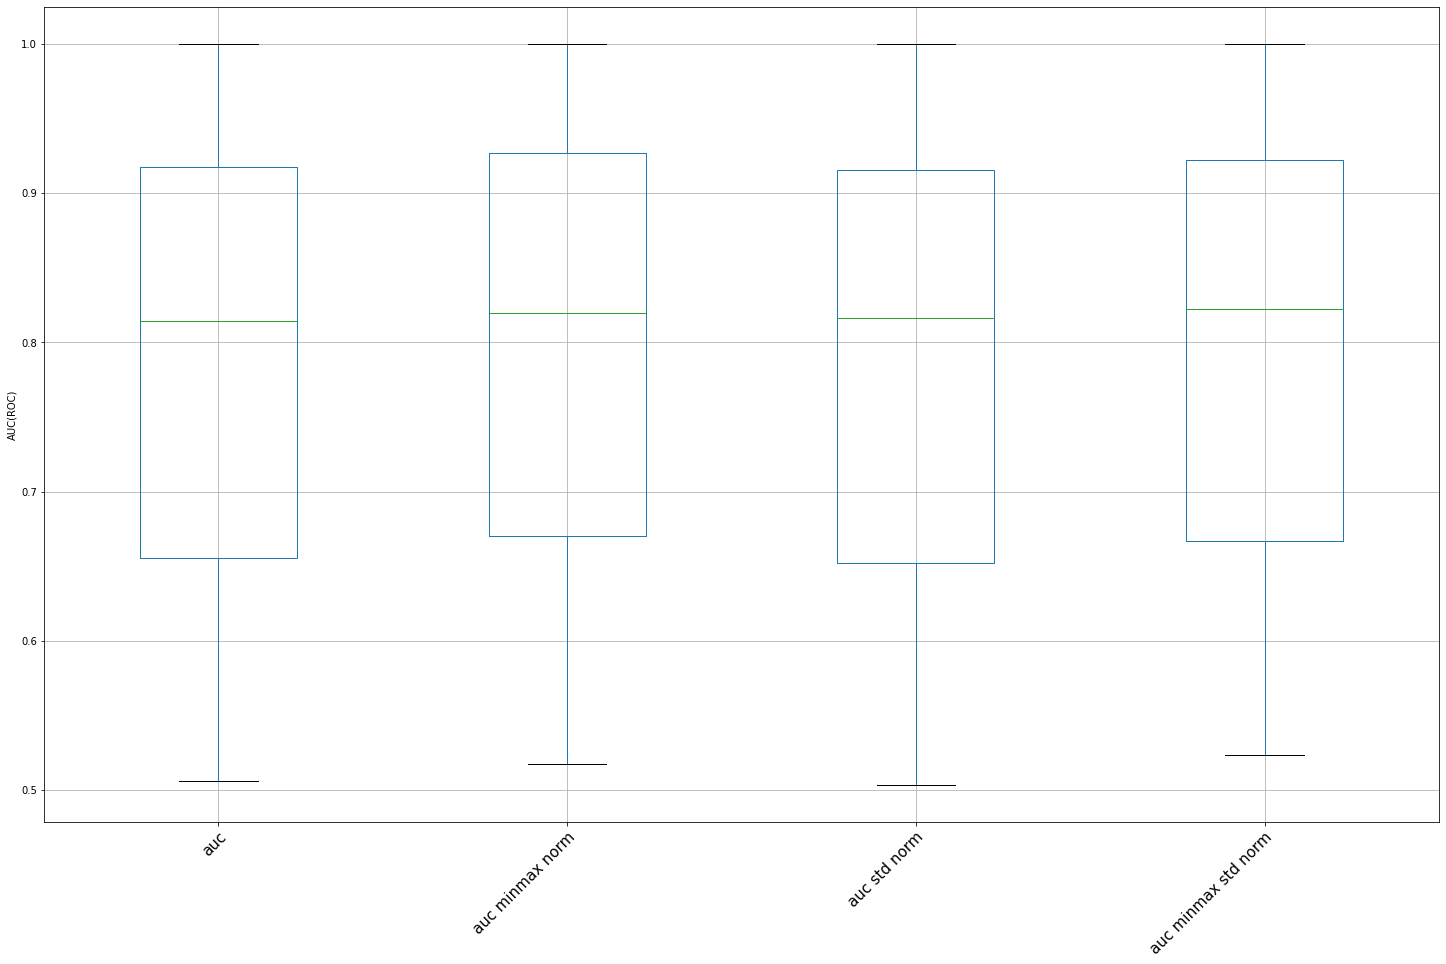

In [ ]:
boxplot_viz('IsolationForest.csv')

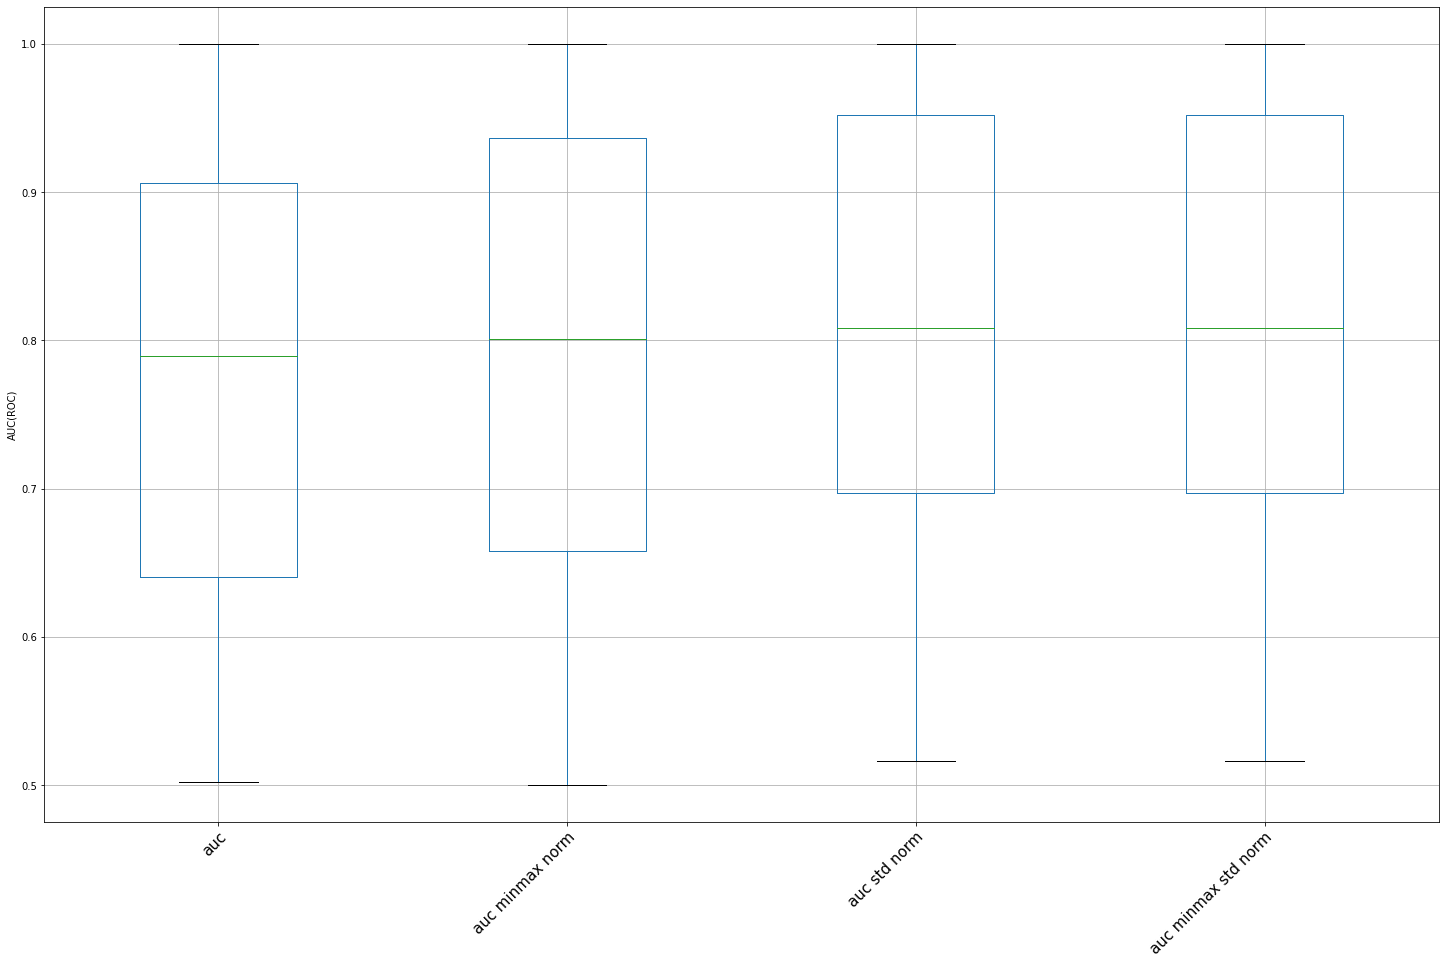

In [ ]:
boxplot_viz('OneClassSVM.csv')

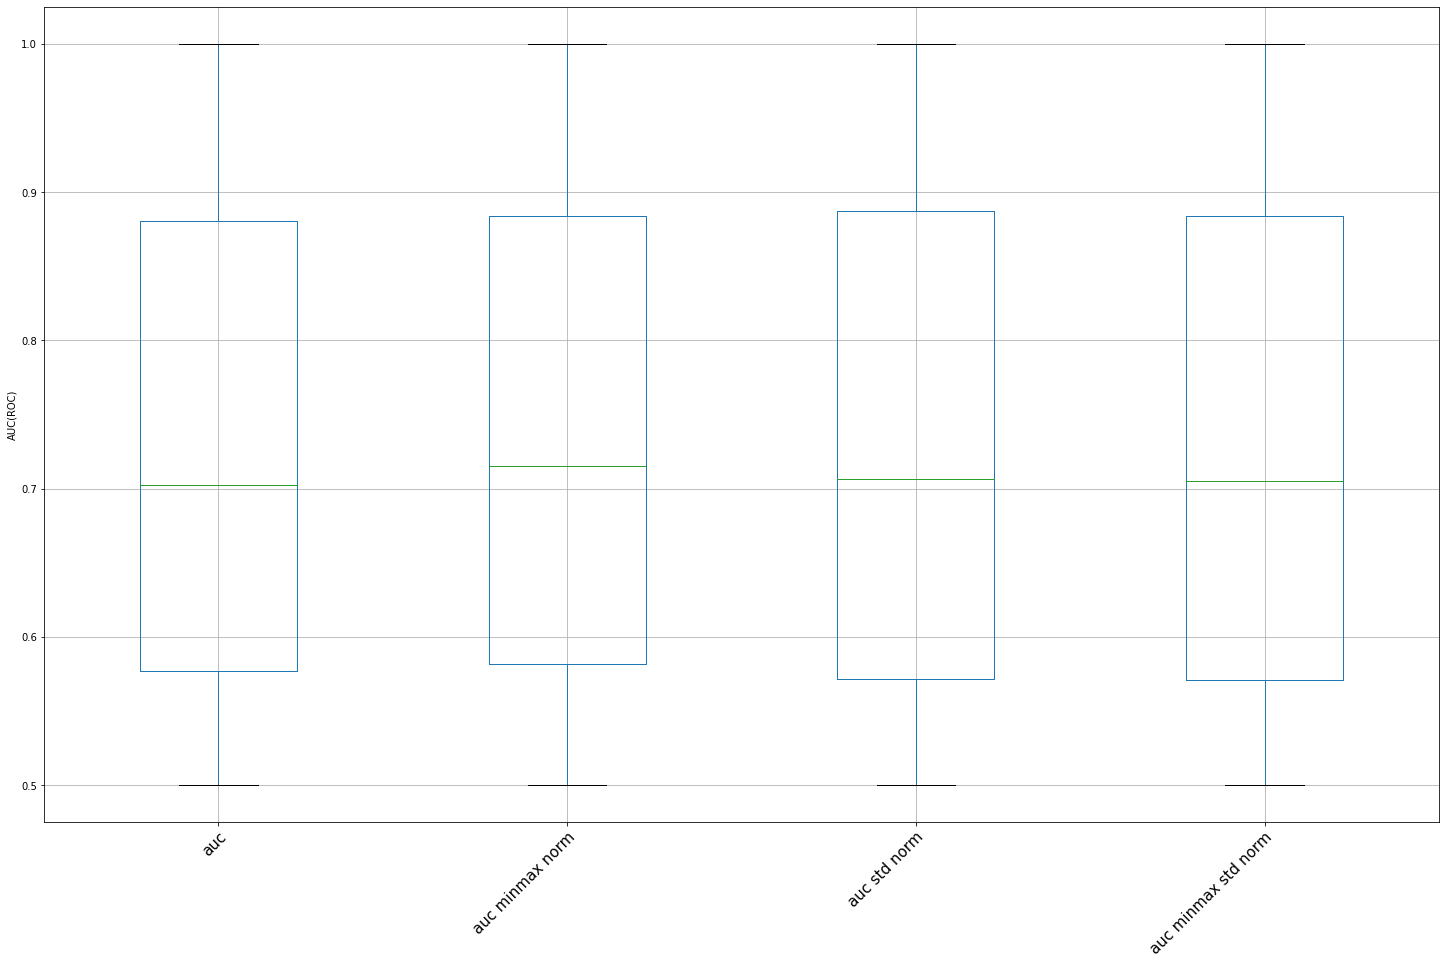

In [ ]:
boxplot_viz('modified_BRM_cosine_similarity_.csv')

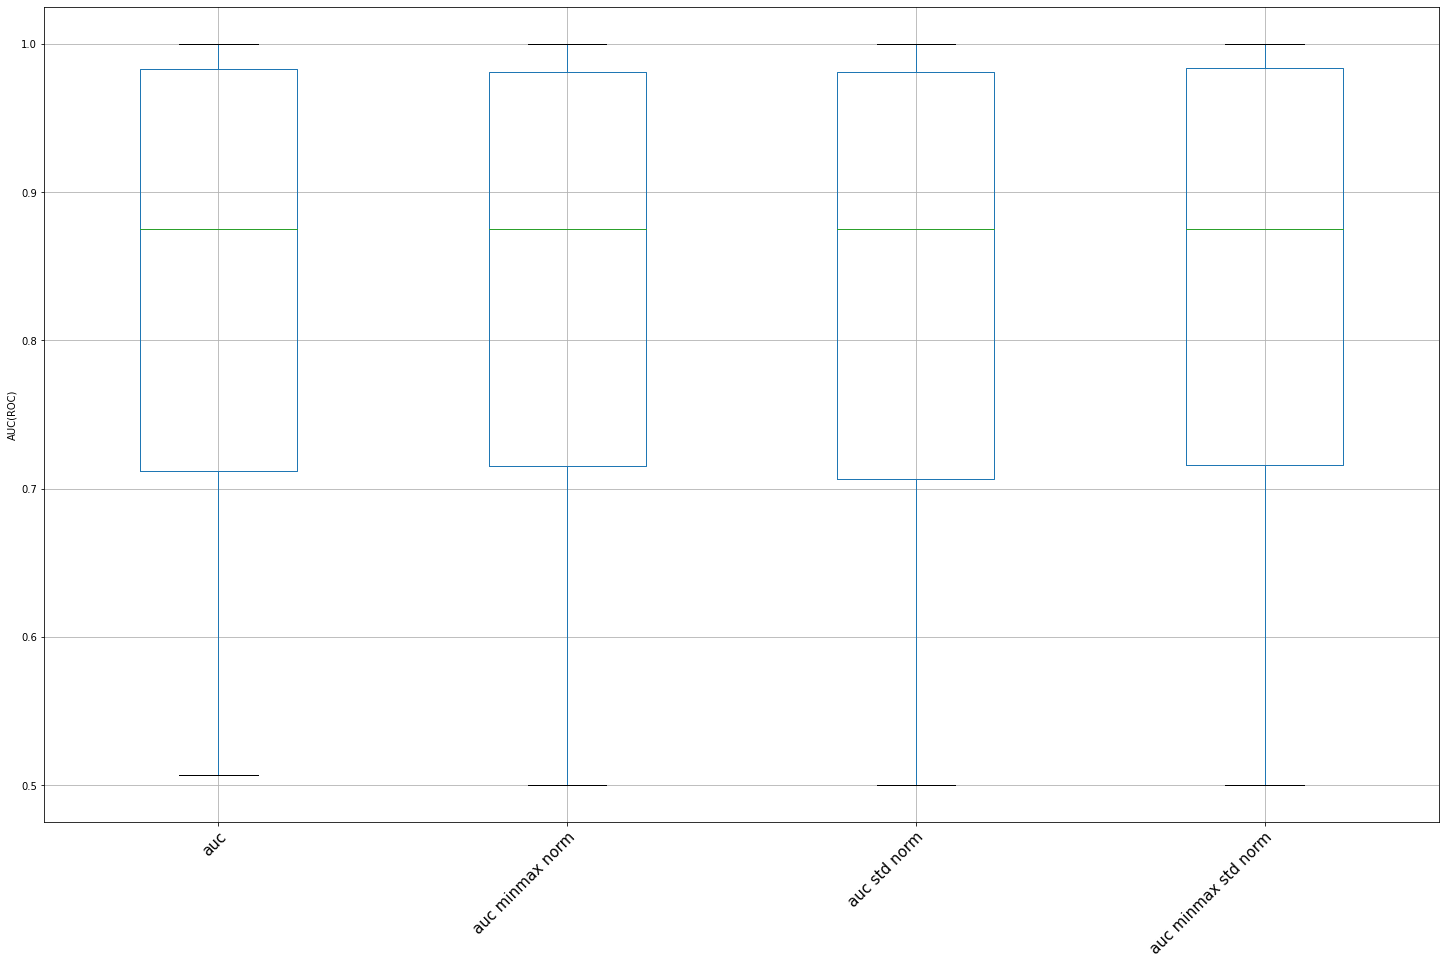

In [ ]:
boxplot_viz('modified_BRM_euclidean_distances_.csv')

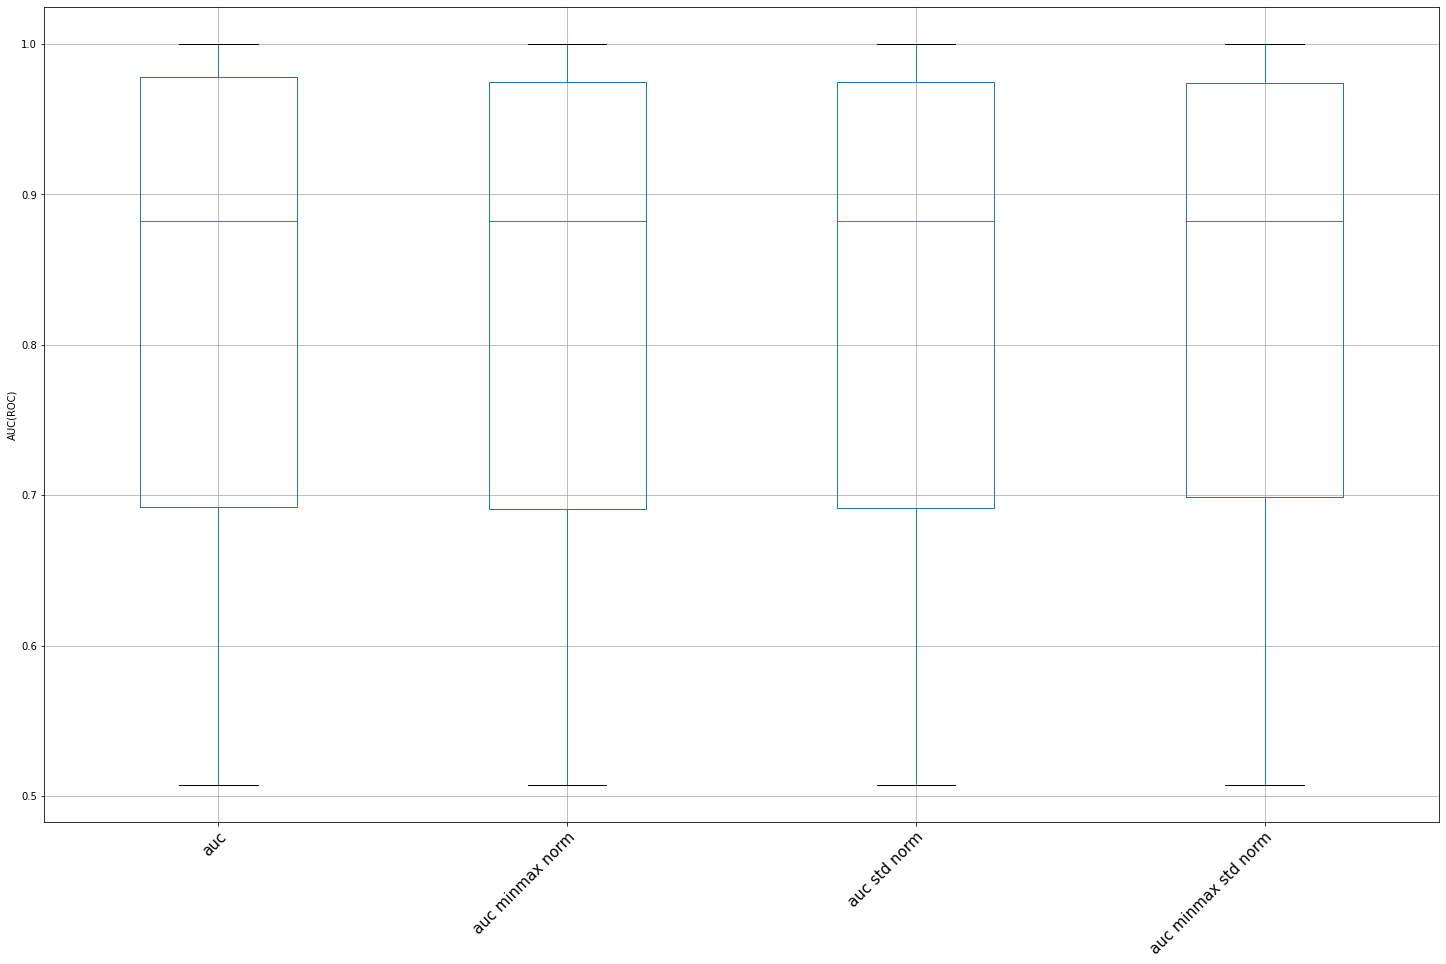

In [ ]:
boxplot_viz('modified_BRM_manhattan_distances_.csv')

FriedmanchisquareResult(statistic=231.47556030286142, pvalue=2.3312246478450808e-36)


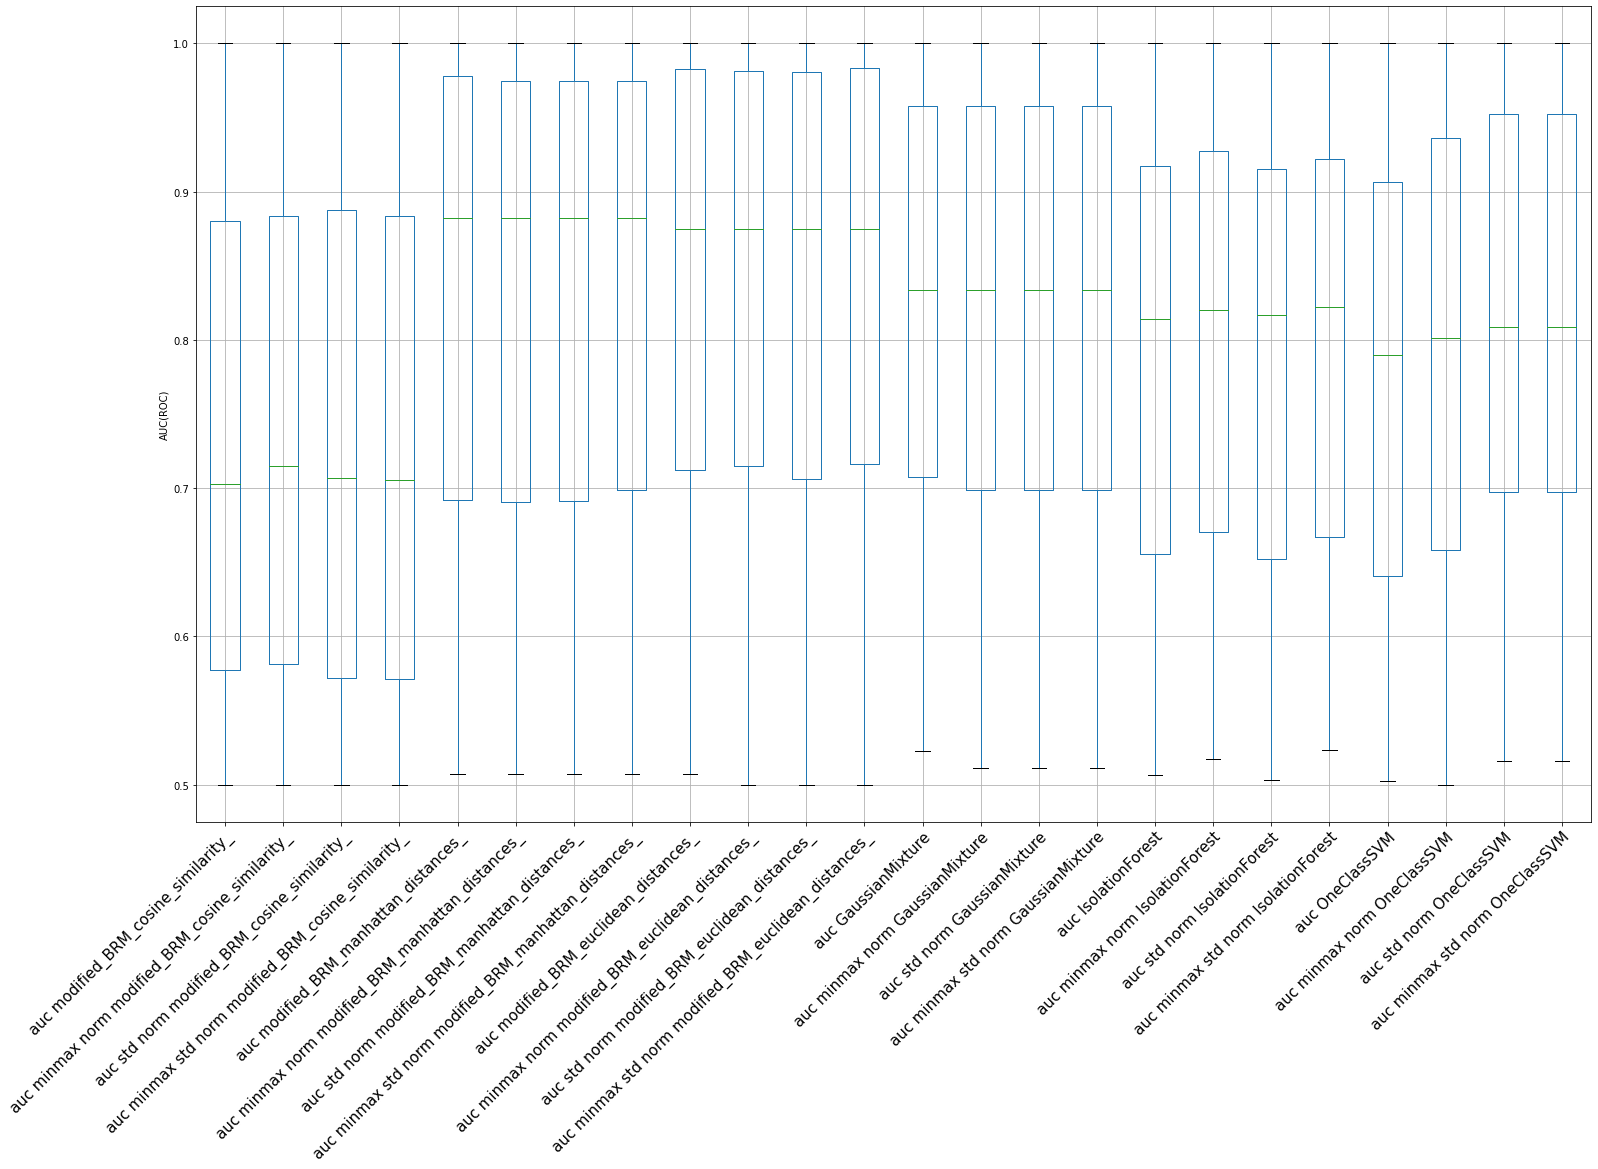

In [ ]:
boxplot_viz('classifiers_auc_results.csv')
Friedman_test('classifiers_auc_results.csv')

## Friedman test with posthoc

In [ ]:
def Friedman_test_with_posthoc(csv_file):
  """ 
  CITA

  @ARTICLE{Terpilowski2019,
  title    = {scikit-posthocs: Pairwise multiple comparison tests in Python},
  author   = {Terpilowski, Maksim},
  journal  = {The Journal of Open Source Software},
  volume   = {4},
  number   = {36},
  pages    = {1169},
  year     = {2019},
  doi      = {10.21105/joss.01169}
  }
  
  """

  df = pd.read_csv(csv_file)
  if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis = 1)
  df = df[df.columns.drop(list(df.filter(regex='folder_name')))]
  # df = df.to_numpy()
  return (sp.posthoc_nemenyi_friedman(df))

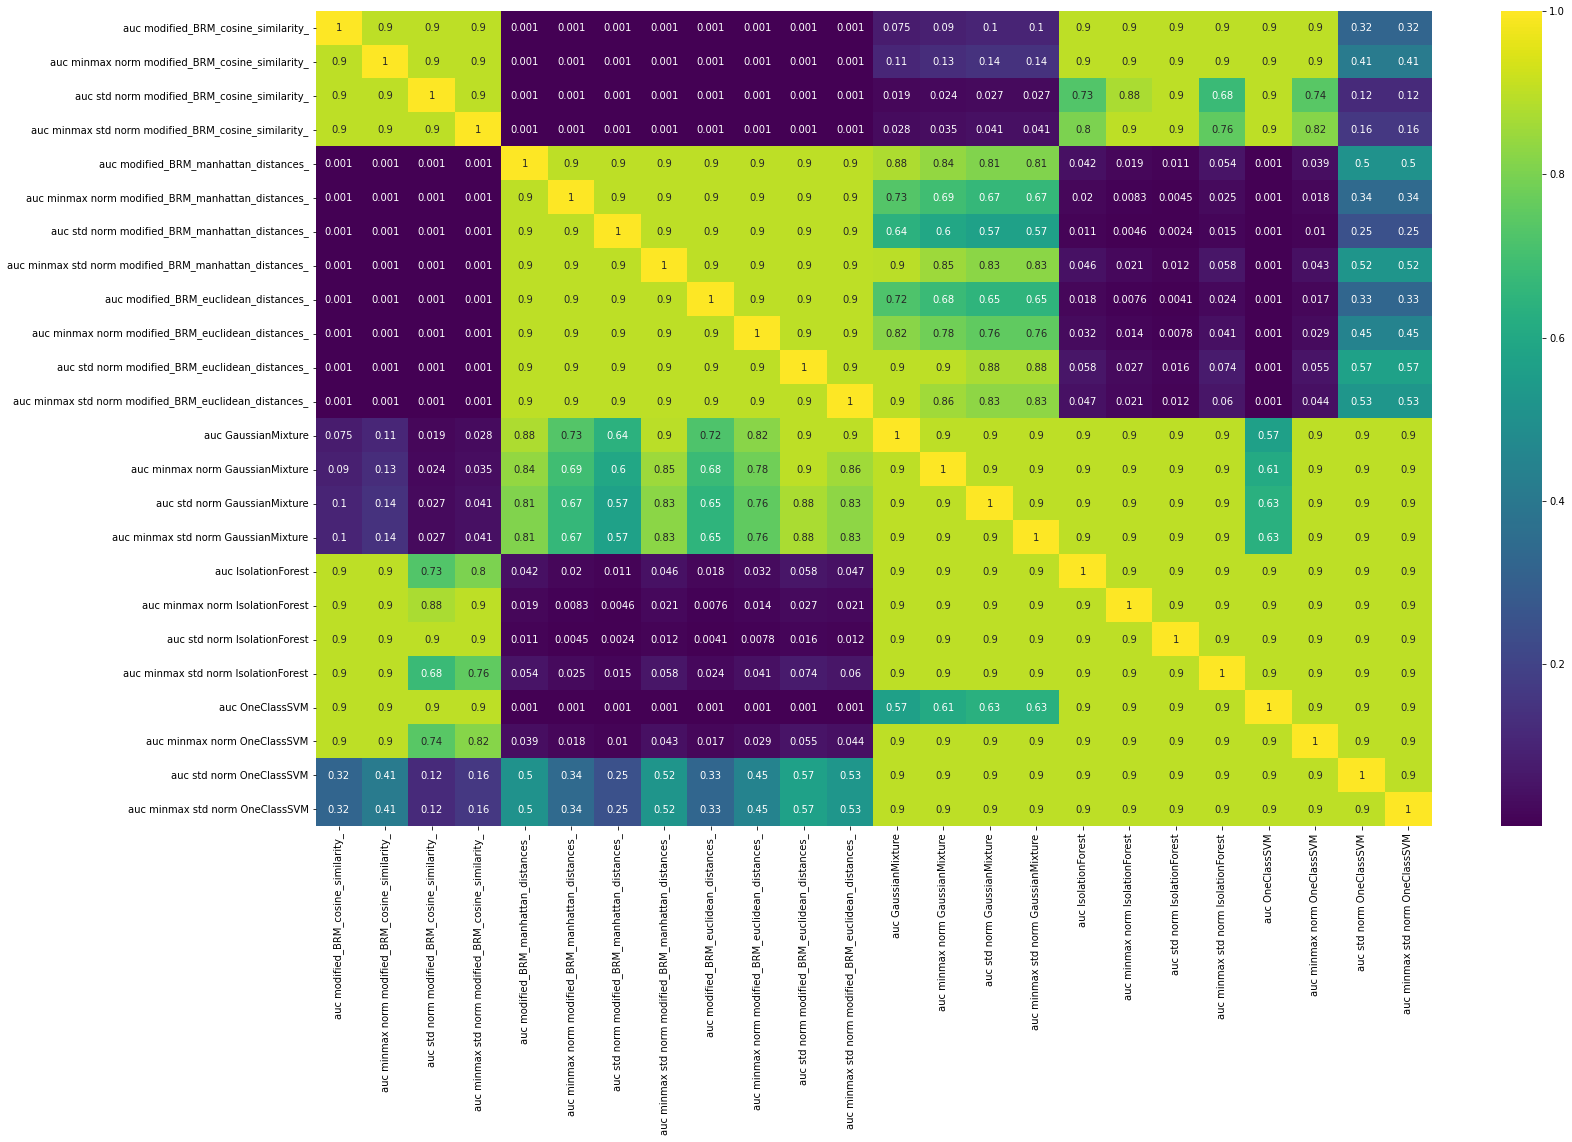

In [ ]:
sns.heatmap(Friedman_test_with_posthoc('classifiers_auc_results.csv'), annot=True, cmap = 'viridis')

In [ ]:
def data_transpose (csv_file):
  df = pd.read_csv(csv_file)
  if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis = 1)
  df = df[df.columns.drop(list(df.filter(regex='folder_name')))]
  # df = df.to_numpy()
  return df.T


In [ ]:
def avranks (csv_file):
  df=data_transpose(csv_file)
  ranks= df.iloc[:, :-1].rank(method='dense', ascending=False).mean(axis=1)
  avranks_methods=pd.DataFrame(ranks).rename(columns={0:'AvgRank'})
  return (avranks_methods)

## CD diagrams

In [ ]:
! pip install orange3
import Orange 
import matplotlib.pyplot as plt

In [ ]:
def CD_diagrams (csv_file):
  df = pd.read_csv(csv_file)
  if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis = 1)
  df = df[df.columns.drop(list(df.filter(regex='folder_name')))]
  names = list(df.columns)
  ranks = avranks (csv_file).reset_index()
  Avgranks= ranks["AvgRank"]
  Orange.evaluation.graph_ranks(Avgranks, names,cd=0.55, width=10, textspace=1.5)
  plt.show();


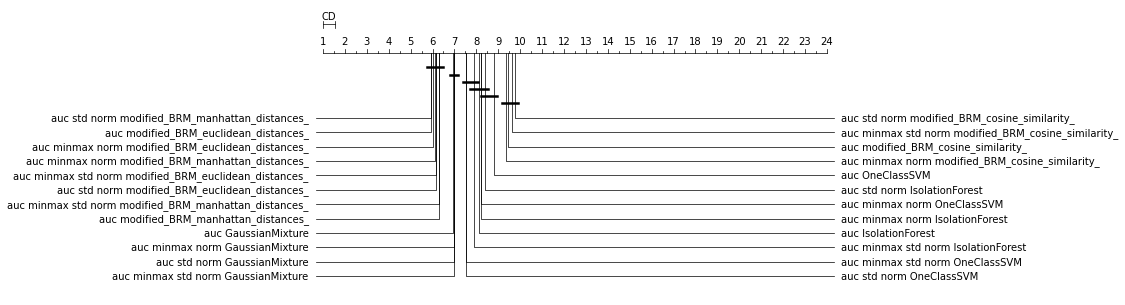

In [ ]:
CD_diagrams ("classifiers_auc_results.csv")